# Basic preprocessing of the pancreatic endocrine dataset

Notebook preprocesses the pancreatic endocrine dataset.

## Library imports

In [1]:
import numpy as np
import pandas as pd

import scanpy as sc
import scvelo as scv
from velovi import preprocess_data

from rgv_tools import DATA_DIR
from rgv_tools.preprocessing import set_prior_grn

/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/home/icb/weixu.wang/miniconda3/envs/regvelo_t

## General settings

In [2]:
sc.settings.verbosity = 2
scv.settings.verbosity = 3

## Constants

In [3]:
DATASET = "pancreatic_endocrine"

SAVE_DATA = True
if SAVE_DATA:
    (DATA_DIR / DATASET / "processed").mkdir(parents=True, exist_ok=True)

## Data loading

In [4]:
adata = sc.read_h5ad(DATA_DIR / DATASET / "raw" / "endocrinogenesis_day15.h5ad")
TF = pd.read_csv(DATA_DIR / DATASET / "raw" / "allTFs_mm.txt", header=None)
gt_net = pd.read_csv(DATA_DIR / DATASET / "raw" / "skeleton_update.csv", index_col=0)

## Preprocessing

In [5]:
scv.pp.filter_and_normalize(adata, min_shared_counts=10, n_top_genes=2000)

Filtered out 19641 genes that are detected 10 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
Logarithmized X.


/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/scvelo/preprocessing/utils.py:705: DeprecationWarning: `log1p` is deprecated since scVelo v0.3.0 and will be removed in a future version. Please use `log1p` from `scanpy.pp` instead.
  log1p(adata)


In [6]:
sc.pp.neighbors(adata, n_neighbors=30, n_pcs=30)

computing neighbors
    using 'X_pca' with n_pcs = 30
    finished (0:00:16)


In [7]:
scv.pp.moments(adata, n_pcs=None, n_neighbors=None)
adata

computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


AnnData object with n_obs × n_vars = 3696 × 2000
    obs: 'clusters_coarse', 'clusters', 'S_score', 'G2M_score', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts'
    var: 'highly_variable_genes', 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'highly_variable'
    uns: 'clusters_coarse_colors', 'clusters_colors', 'day_colors', 'neighbors', 'pca', 'log1p'
    obsm: 'X_pca', 'X_umap'
    layers: 'spliced', 'unspliced', 'Ms', 'Mu'
    obsp: 'distances', 'connectivities'

/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/s

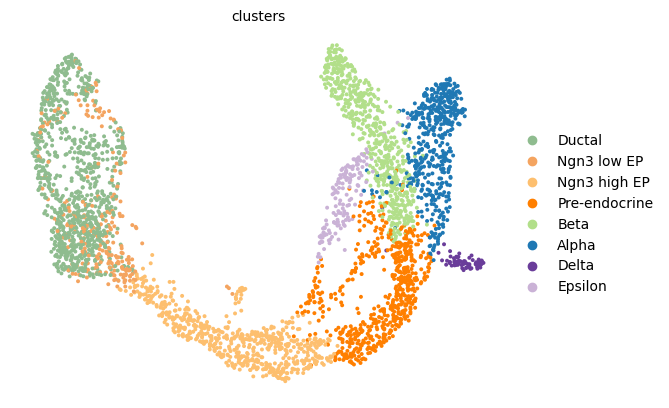

In [8]:
scv.pl.umap(adata, color="clusters", legend_loc="right")

## RegVelo preprocessing

In [9]:
adata = set_prior_grn(adata, gt_net, keep_dim=True)  ## keep_dim = True due to the the sparse prior GRN

In [10]:
velocity_genes = preprocess_data(adata.copy()).var_names.tolist()

computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


In [11]:
tf_grn = adata.var_names[adata.uns["skeleton"].T.sum(0) != 0].tolist()
tfs = list(set(TF.iloc[:, 0].tolist()).intersection(tf_grn))
adata.var["tf"] = adata.var_names.isin(tfs)

In [12]:
var_mask = np.union1d(adata.var_names[adata.var["tf"]], velocity_genes)
adata = adata[:, var_mask].copy()

In [13]:
adata = preprocess_data(adata, filter_on_r2=False)

In [14]:
# Filter the skeleton matrix `W` based on the selected indices
skeleton = adata.uns["skeleton"].loc[adata.var_names.tolist(), adata.var_names.tolist()]

# Update the filtered values in `uns`
adata.uns.update({"skeleton": skeleton, "regulators": adata.var_names.tolist(), "targets": adata.var_names.tolist()})

In [15]:
## focus on velocity genes to ensure calculation stability of scvelo and veloVI
adata.var["velocity_genes"] = adata.var_names.isin(velocity_genes)

## Save dataset

In [16]:
if SAVE_DATA:
    adata.write_h5ad(DATA_DIR / DATASET / "processed" / "adata_preprocessed.h5ad")